# Pose Classification using Tensorflow

### Introduction
Using kaggle dataset to detect 5 yoga poses using tensorflow.
First I will try Logistic Regression and then Convolutional Neural Network.


## Logistic Regression

In [1]:
import numpy as np
import cv2
from tqdm import tqdm
import os
import itertools
from skimage import transform
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve,confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras import Sequential
from tensorflow.python.client import device_lib
import tensorflow as tf

train_path = "C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TRAIN/"
test_path = "C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TEST/"

In [2]:
# For using NVIDIA GPU to perform computations for training and testing

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1976509688582916609
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9383706624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11891944838005821854
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10084155392
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7770180507221075596
physical_device_desc: "device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
# Preprocessing Data

# resize the input images and covert them into numpy array
'''
path = path to the folder containing the images
img_size = size of the image
num_images = number of images to read from each folder
images_output_name = name of the numpy array to save the images
labels_output_name = name of the numpy array to save the labels
'''
def preprocess_input_data(path, img_size, images_output_name, labels_output_name, num_images=300):
    
    labels = [] # holds the names of images
    images = [] # holds the pixel values of images
    i = 0
    for idx,img in enumerate(os.listdir(path)):
        for img_name in tqdm(os.listdir(path+img)):
            if i<num_images:
                img_file= cv2.imread(path + img + '/' + img_name)
                if img_file is not None:
                    img_file= transform.resize(img_file, (img_size, img_size, 3))
                    images.append(img_file)
                    labels.append(idx)
            else:
                break
            i=i+1
        i=0
    images = np.asarray(images)
    labels = np.asarray(labels)

    # Save the arrays
    images_output_name = images_output_name + '.npy'
    labels_output_name = labels_output_name + '.npy'

    with open(images_output_name, 'wb') as f:
        np.save(f, images)

    with open(labels_output_name, 'wb') as f:
        np.save(f, labels)



In [4]:
# Load the original raw image data and convert them into numpy arrays

path = "C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TRAIN/"
img_size = 224
images_output_name = 'np_images'
labels_output_name = 'np_labels'

preprocess_input_data(path, img_size, images_output_name, labels_output_name, num_images=300)

100%|██████████| 252/252 [00:44<00:00,  5.64it/s]


In [5]:
# load the data
X = np.load('np_images.npy')
t = np.load('np_labels.npy')

# Split into training and validation sets
X_train, X_val, t_train, t_val = train_test_split(X, t, test_size=0.2, random_state=42)

In [6]:
# Flatten the images to 2D

n_samples, nx, ny, nz = X_train.shape
X_train_flat = X_train.reshape(n_samples, nx*ny*nz)

m_samples, mx, my, mz = X_val.shape
X_val_flat = X_val.reshape(m_samples, mx*my*mz)

In [7]:
# Scale data
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)

In [8]:
# Reduce the dimensionality of the data using PCA
pca = PCA(n_components=0.95)
X_train_flat = pca.fit_transform(X_train_flat)
X_val_flat = pca.transform(X_val_flat)

In [9]:
# Logistic Regression
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

with tf.device('/gpu:0'):

    log_reg.fit(X_train_flat, t_train)

C:\Users\jaisw\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
# Accuracy on training set
print('Accuracy of logistic regression on training set: ',log_reg.score(X_train_flat, t_train))

Accuracy of logistic regression on training set:  1.0


In [11]:
# Predict the labels for validation set
t_pred = log_reg.predict(X_val_flat)
print('Accuracy of logistic regression on validation set: ',accuracy_score(t_val, t_pred))

Accuracy of logistic regression on validation set:  0.6451612903225806


In [12]:
# Confusion matrix
confusion_matrix(t_val, t_pred)


array([[30,  4,  4,  3,  4],
       [ 2, 23,  4,  1,  4],
       [ 7, 10, 35,  0,  3],
       [ 2,  2,  1, 23,  0],
       [ 4, 10,  3,  9, 29]], dtype=int64)

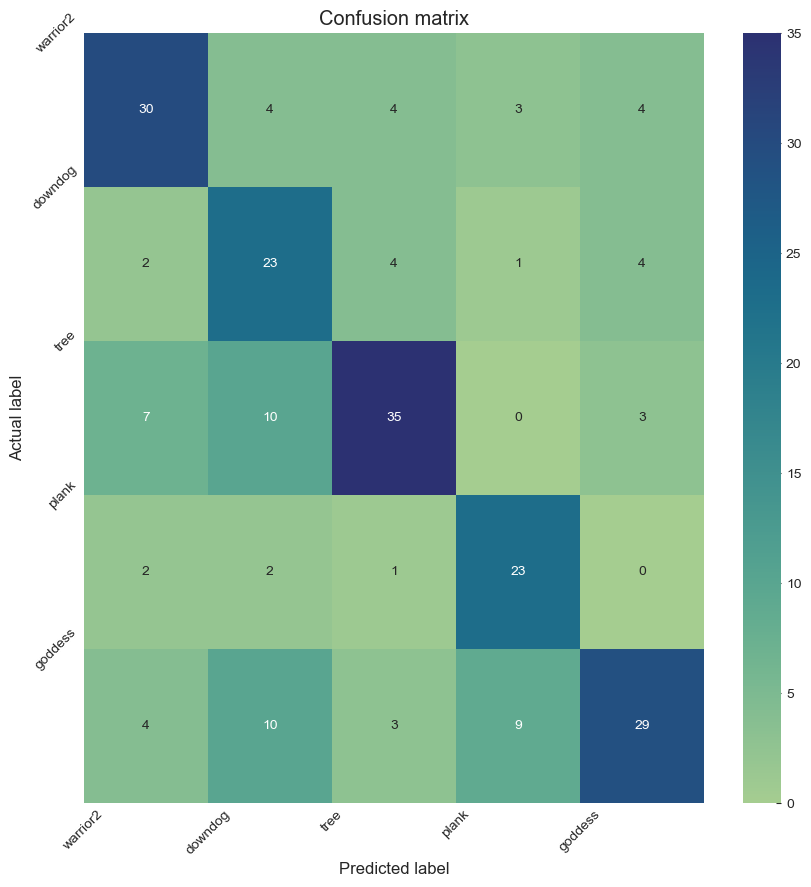

In [16]:
# Plot the confusion matrix
cm = confusion_matrix(t_val, t_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="crest")
labels = ['warrior2', 'downdog', 'tree', 'plank', 'goddess']
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels, rotation=45)
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

---

# CNN from Scratch

In [59]:

# Preprocessing Data

# Preprocess images and split into training and validation sets
# Using VGG16 preprocessing

train_path = "C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TRAIN/"
test_path = "C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TEST/"
img_size = 224
image_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, validation_split=0.2)

train_dataset = image_generator.flow_from_directory(batch_size=10,
                                                    directory=train_path,
                                                    shuffle=True,
                                                    target_size=(img_size, img_size),
                                                    subset="training",
                                                    classes=['warrior2', 'downdog', 'tree', 'plank', 'goddess'])

validation_dataset = image_generator.flow_from_directory(batch_size=10,
                                                         directory=train_path,
                                                         shuffle=True,
                                                         target_size=(img_size, img_size),
                                                         subset="validation",
                                                         classes=['warrior2', 'downdog', 'tree', 'plank', 'goddess'])



Found 866 images belonging to 5 classes.
Found 215 images belonging to 5 classes.


In [60]:

# Build CNN with no early stopping or drop out layers
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same',
           input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=5, activation='softmax'),
])

# compile model
# optimizer_adam = Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# fit model
history = 0
with tf.device('/gpu:0'):
    history = model.fit(x=train_dataset, validation_data=validation_dataset, epochs=10, verbose=2)


Epoch 1/10


C:\Users\jaisw\anaconda3\envs\tf-gpu\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


87/87 - 15s - loss: 152.5358 - accuracy: 0.2413 - val_loss: 1.5846 - val_accuracy: 0.2186
Epoch 2/10
87/87 - 14s - loss: 1.5238 - accuracy: 0.3764 - val_loss: 1.5514 - val_accuracy: 0.2977
Epoch 3/10
87/87 - 13s - loss: 1.2256 - accuracy: 0.5416 - val_loss: 1.3940 - val_accuracy: 0.4605
Epoch 4/10
87/87 - 15s - loss: 0.7052 - accuracy: 0.7748 - val_loss: 1.6146 - val_accuracy: 0.4977
Epoch 5/10
87/87 - 14s - loss: 0.2163 - accuracy: 0.9365 - val_loss: 1.6901 - val_accuracy: 0.5163
Epoch 6/10
87/87 - 16s - loss: 0.1092 - accuracy: 0.9734 - val_loss: 2.4962 - val_accuracy: 0.4698
Epoch 7/10
87/87 - 13s - loss: 0.0390 - accuracy: 0.9919 - val_loss: 2.4006 - val_accuracy: 0.5116
Epoch 8/10
87/87 - 13s - loss: 0.0943 - accuracy: 0.9827 - val_loss: 2.4589 - val_accuracy: 0.5070
Epoch 9/10
87/87 - 14s - loss: 0.0266 - accuracy: 0.9942 - val_loss: 3.4977 - val_accuracy: 0.5395
Epoch 10/10
87/87 - 14s - loss: 0.0400 - accuracy: 0.9931 - val_loss: 2.8973 - val_accuracy: 0.4977


In [35]:
# get predictions
predictions = 0
with tf.device('/gpu:0'):

    predictions = model.predict(x=validation_dataset, steps=len(validation_dataset), verbose=0)

In [36]:
predicted_class_indices = np.argmax(predictions, axis=1)
labels = (validation_dataset.class_indices)
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]


In [37]:
accuracy_score(validation_dataset.labels, predicted_class_indices)

0.17209302325581396

In [38]:
# Save the model
model.save('CNN_without_VGG.h5')



In [39]:
confusion_matrix(validation_dataset.labels, predicted_class_indices)

array([[10, 16,  6, 12,  6],
       [16, 10,  5, 10,  3],
       [12,  5,  4,  7,  4],
       [12, 15,  7, 11,  8],
       [13,  3, 10,  8,  2]], dtype=int64)

In [40]:
from sklearn.metrics import classification_report

print(classification_report(validation_dataset.labels, predicted_class_indices, target_names=['warrior2', 'downdog', 'tree', 'plank', 'goddess']))

              precision    recall  f1-score   support

    warrior2       0.16      0.20      0.18        50
     downdog       0.20      0.23      0.22        44
        tree       0.12      0.12      0.12        32
       plank       0.23      0.21      0.22        53
     goddess       0.09      0.06      0.07        36

    accuracy                           0.17       215
   macro avg       0.16      0.16      0.16       215
weighted avg       0.17      0.17      0.17       215



In [41]:
precision_score(validation_dataset.labels, predicted_class_indices, average='weighted')

0.168336594833417

In [42]:
recall_score(validation_dataset.labels, predicted_class_indices, average='weighted')

0.17209302325581396

In [43]:
f1_score(validation_dataset.labels, predicted_class_indices, average='weighted')

0.16882397923287898

### Adding drop out layers

In [44]:

# Build CNN with dropout layers
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same',
           input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.8),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.5),
    Flatten(),
    Dense(units=5, activation='softmax'),
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit model
with tf.device('/gpu:1'):
    history = model.fit(x=train_dataset, validation_data=validation_dataset, epochs=10, verbose=2)

Epoch 1/10


C:\Users\jaisw\anaconda3\envs\tf-gpu\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


87/87 - 17s - loss: 898.7666 - accuracy: 0.2286 - val_loss: 1.6119 - val_accuracy: 0.1674
Epoch 2/10
87/87 - 14s - loss: 5.0763 - accuracy: 0.2587 - val_loss: 1.6141 - val_accuracy: 0.1674
Epoch 3/10
87/87 - 14s - loss: 3.8689 - accuracy: 0.2275 - val_loss: 1.6144 - val_accuracy: 0.1674
Epoch 4/10
87/87 - 13s - loss: 3.2575 - accuracy: 0.2610 - val_loss: 1.6138 - val_accuracy: 0.1674
Epoch 5/10
87/87 - 15s - loss: 2.8527 - accuracy: 0.2610 - val_loss: 1.6139 - val_accuracy: 0.1674
Epoch 6/10
87/87 - 13s - loss: 2.5100 - accuracy: 0.2633 - val_loss: 1.6133 - val_accuracy: 0.1674
Epoch 7/10
87/87 - 13s - loss: 2.2446 - accuracy: 0.2841 - val_loss: 1.6128 - val_accuracy: 0.1674
Epoch 8/10
87/87 - 17s - loss: 2.1657 - accuracy: 0.2933 - val_loss: 1.6124 - val_accuracy: 0.1674
Epoch 9/10
87/87 - 15s - loss: 1.9532 - accuracy: 0.3152 - val_loss: 1.6114 - val_accuracy: 0.1674
Epoch 10/10
87/87 - 14s - loss: 1.9479 - accuracy: 0.3095 - val_loss: 1.6103 - val_accuracy: 0.1674


In [45]:
pred = model.predict(x=validation_dataset, steps=len(validation_dataset), verbose=1)
predicted_class_indices = np.argmax(pred, axis=1)
labels = (validation_dataset.class_indices)
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

22/22 [==============================] - 2s 99ms/step


215

In [46]:
print(classification_report(validation_dataset.labels, predicted_class_indices, target_names=['warrior2', 'downdog', 'tree', 'plank', 'goddess']))

              precision    recall  f1-score   support

    warrior2       0.00      0.00      0.00        50
     downdog       0.00      0.00      0.00        44
        tree       0.00      0.00      0.00        32
       plank       0.00      0.00      0.00        53
     goddess       0.17      1.00      0.29        36

    accuracy                           0.17       215
   macro avg       0.03      0.20      0.06       215
weighted avg       0.03      0.17      0.05       215



C:\Users\jaisw\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jaisw\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jaisw\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
confusion_matrix(validation_dataset.labels, predicted_class_indices)

array([[ 0,  0,  0,  0, 50],
       [ 0,  0,  0,  0, 44],
       [ 0,  0,  0,  0, 32],
       [ 0,  0,  0,  0, 53],
       [ 0,  0,  0,  0, 36]], dtype=int64)

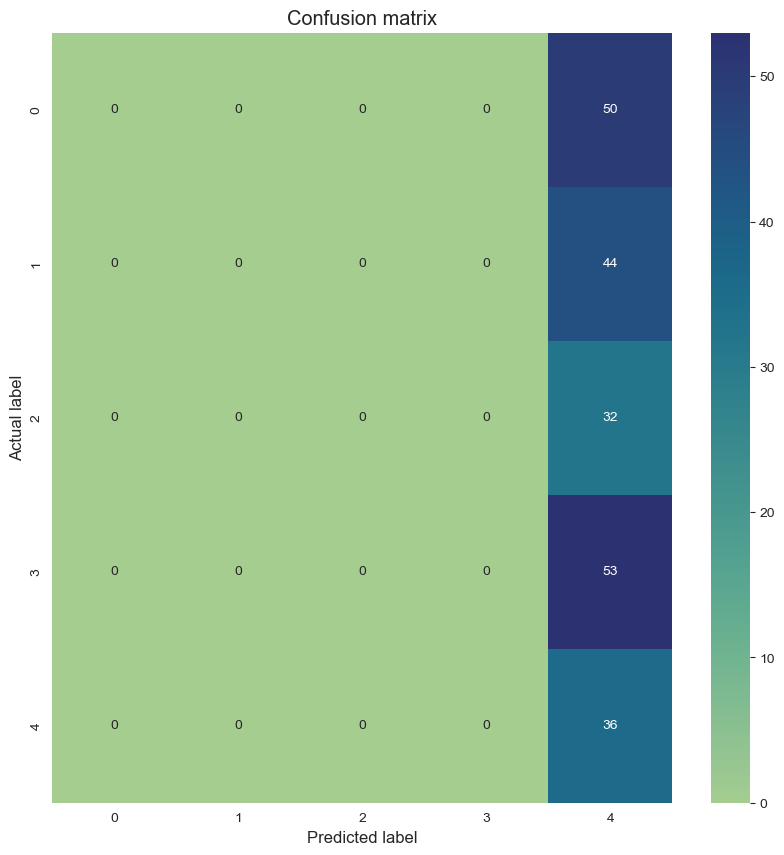

In [50]:
# Plot the confusion matrix
import seaborn as sns
cm = confusion_matrix(validation_dataset.labels, predicted_class_indices)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='crest')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


## Convolutional Neural Network with transfer learning

In [17]:

# Preprocessing Data

# Preprocess images and split into training and validation sets
# Using VGG16 preprocessing

train_path = "C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TRAIN/"
test_path = "C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TEST/"
img_size = 224
image_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, validation_split=0.2)

train_dataset = image_generator.flow_from_directory(batch_size=10,
                                                    directory=train_path,
                                                    shuffle=True,
                                                    target_size=(img_size, img_size),
                                                    subset="training",
                                                    classes=['warrior2', 'downdog', 'tree', 'plank', 'goddess'])

validation_dataset = image_generator.flow_from_directory(batch_size=10,
                                                         directory=train_path,
                                                         shuffle=True,
                                                         target_size=(img_size, img_size),
                                                         subset="validation",
                                                         classes=['warrior2', 'downdog', 'tree', 'plank', 'goddess'])



Found 866 images belonging to 5 classes.
Found 215 images belonging to 5 classes.


In [23]:
# Build the model
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16

# Load the VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers
for layer in vgg16.layers:
    layer.trainable = False

# Add the last layer
x = layers.Flatten()(vgg16.output)
x = layers.Dense(5, activation='softmax')(x)

model = Model(vgg16.input, x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [24]:
# Train the model

with tf.device('/gpu:0'):
    history = model.fit(train_dataset,
                    steps_per_epoch=10,
                    epochs=10,
                    validation_data=validation_dataset,
                    validation_steps=10,
                    verbose=1)


Epoch 1/10
10/10 [==============================] - 4s 275ms/step - loss: 11.7368 - accuracy: 0.5300 - val_loss: 9.3118 - val_accuracy: 0.6300
Epoch 2/10
10/10 [==============================] - 2s 259ms/step - loss: 8.5122 - accuracy: 0.6200 - val_loss: 11.7530 - val_accuracy: 0.7100
Epoch 3/10
10/10 [==============================] - 3s 268ms/step - loss: 11.2013 - accuracy: 0.7400 - val_loss: 11.0951 - val_accuracy: 0.7000
Epoch 4/10
10/10 [==============================] - 3s 289ms/step - loss: 8.6673 - accuracy: 0.8100 - val_loss: 7.4306 - val_accuracy: 0.7900
Epoch 5/10
10/10 [==============================] - 2s 241ms/step - loss: 4.9972 - accuracy: 0.8700 - val_loss: 12.0764 - val_accuracy: 0.8000
Epoch 6/10
10/10 [==============================] - 3s 304ms/step - loss: 8.0330 - accuracy: 0.7400 - val_loss: 8.2557 - val_accuracy: 0.7800
Epoch 7/10
10/10 [==============================] - 2s 240ms/step - loss: 3.1987 - accuracy: 0.9000 - val_loss: 5.6760 - val_accuracy: 0.8500
E

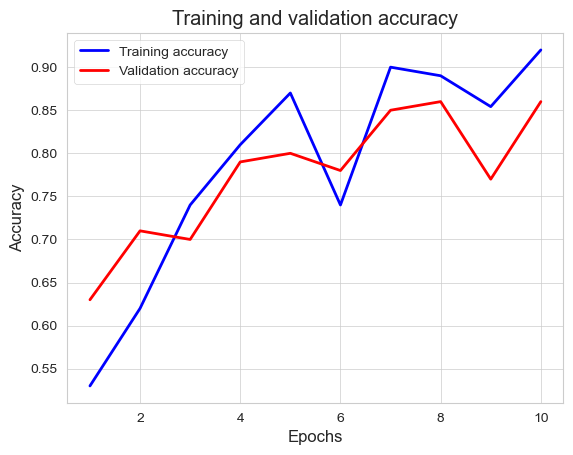

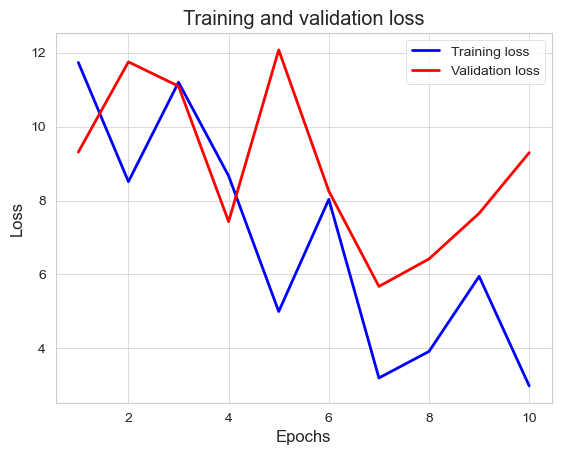

In [25]:
# Plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt

# Get the history dictionary
history_dict = history.history

# Plot the training and validation accuracy and loss at each epoch
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plot the training and validation accuracy
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.clf()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [26]:
# Save the model
model.save('yoga_pose_classifier.h5')



## Testing on Test Dataset

In [27]:
# Load the model
from tensorflow.keras.models import load_model
model = load_model('yoga_pose_classifier.h5')



---

In [61]:

# Preprocessing test data

# Preprocess images and split into training and validation sets
# Using VGG16 preprocessing

#train_path = "C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TRAIN/"
test_path = "C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TEST/"
img_size = 224
image_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

test_dataset = image_generator.flow_from_directory(batch_size=32,
                                                         directory=test_path,
                                                         shuffle=True,
                                                         target_size=(img_size, img_size),
                                                         classes=['warrior2', 'downdog', 'tree', 'plank', 'goddess'])



Found 470 images belonging to 5 classes.


In [62]:
# Load model
model = tf.keras.models.load_model('yoga_pose_model.h5')



In [63]:
# Test model
pred = model.predict(x=test_dataset, steps=len(test_dataset), verbose=1)
predicted_class_indices = np.argmax(pred, axis=1)
labels = (test_dataset.class_indices)
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
len(predictions)


15/15 [==============================] - 15s 826ms/step


470

In [64]:
accuracy_score(test_dataset.labels, predicted_class_indices)

0.2170212765957447

In [65]:
print(classification_report(test_dataset.labels, predicted_class_indices, target_names=['warrior2', 'downdog', 'tree', 'plank', 'goddess']))

              precision    recall  f1-score   support

    warrior2       0.21      0.27      0.24       109
     downdog       0.27      0.26      0.27        97
        tree       0.14      0.13      0.13        69
       plank       0.23      0.22      0.22       115
     goddess       0.20      0.17      0.19        80

    accuracy                           0.22       470
   macro avg       0.21      0.21      0.21       470
weighted avg       0.22      0.22      0.22       470



In [66]:
confusion_matrix(test_dataset.labels, predicted_class_indices)

array([[29, 22, 11, 30, 17],
       [24, 25, 15, 19, 14],
       [20, 11,  9, 17, 12],
       [35, 24, 18, 25, 13],
       [27,  9, 13, 17, 14]], dtype=int64)

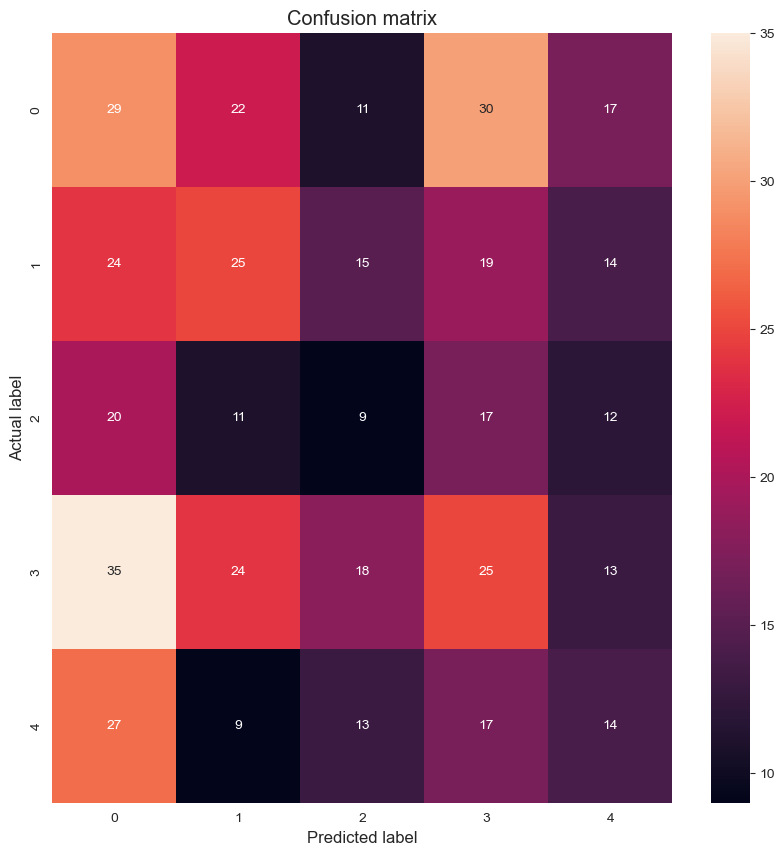

In [67]:
# Plot the confusion matrix
import seaborn as sns
cm = confusion_matrix(test_dataset.labels, predicted_class_indices)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


# MoveNet model

In [68]:

import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [83]:
# Load MoveNet Thunder model
import utils
from data import BodyPart
import tqdm
# from ml import MoveNet
from movenet import Movenet
movenet = Movenet('movenet_thunder')

In [84]:
# Define function to run pose estimation using MoveNet Thunder
def detect(input_tensor, inference_count=3):
    '''Runs detection on an input image.

    Args:
      input_tensor: A [height, width, 3] tensor of type tf.float32.
          Note that height and width can be anything since the image
          will be immediately resized according to the needs of the
          model within this function.
      inference_count: Number of times the model should run repeatedly
          on the same input image to improve detection accuracy.

    Returns:
      A person entity detected by the MoveNet.SinglePose
    '''

    image_height, image_width, channel = input_tensor.shape

    # Detect pose using the full input image
    movenet.detect(input_tensor.numpy(), reset_crop_region=True)

    # Repeatedly using previous detection result to identify the
    # region of interest and only cropping that region to improve
    # detection accuracy
    for _ in range(inference_count - 1):
        person = movenet.detect(input_tensor.numpy(),
                                reset_crop_region=False)

    return person

    # title functions to visualize the pose estimation results

def draw_prediction_on_image(
        image, person, crop_region=None, close_figure=True,
        keep_input_size=False):
    """Draws the keypoint predictions on image.

    Args:
    image: A numpy array with shape [height, width, channel] representing
        the pixel values of the input image.
    person: A person entity returned from the MoveNet.SinglePose model.
    close_figure: Whether to close the plt figure after the function returns.
    keep_input_size: Whether to keep the size of the input image.

    Returns:
      A numpy array with shape [out_height, out_width, channel] representing
      the image overlaid with keypoint predictions.
    """
    # Draw the detection result on top of the image.
    image_np = utils.visualize(image, [person])

    # Plot the image with detection results.
    height, width, channel = image.shape
    aspect_ratio = float(width) / height
    fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
    im = ax.imshow(image_np)

    if close_figure:
        plt.close(fig)

    if not keep_input_size:
        image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

    return image_np

    # Load images, detect pose landmarks and save to CSV
class MoveNetPreprocessor(object):
    """Helper class to preprocess pose sample images for classification."""

    def __init__(self,
                 images_in_folder,
                 images_out_folder,
                 csvs_out_path):
        """Creates a preprocessor to detect pose from images and save as csv.

        Args:
          images_in_folder: Path to folder with input images. It should follow
              this structure:
              yoga_poses
              |__ downdog
                  |______ 00000128.jpg
                  |______ 00000181.bmp
                  |______ ...
              |__ goddess
                  |______ 00000243.jpg
                  |______ 00000306.jpg
                  |______ ...
              ...
          images_out_folder: Path to write the images overlay with detected
              landmarks. These images are useful when you need to debug
              accuracy issues.
          csvs_out_path: Path to write the CSV containing the detected landmark
              coordinates and label of each image than can be used to train a
              pose classification model.
        """
        self._images_in_folder = images_in_folder
        self._images_out_folder = images_out_folder
        self._csvs_out_path = csvs_out_path
        self._messages = []

        # Create a temp dir to store the pose CSVs per class
        self._csvs_out_folder_per_class = tempfile.mkdtemp()

        # Get list of pose classes and print image statistics
        self._pose_class_names = sorted(
            [n for n in os.listdir(self._images_in_folder) if not \
                n.startswith('.')])

    def process(self, per_pose_class_limit=None, detection_threshold=0.1):
        """Preprocesses images in the given folder.
        Args:
          per_pose_class_limit: No. images to load.
          detection_threshold: Only keep images with all landmark confidence
              score above this threshold
        """
        # Loop through the classes and preprocess its images
        for pose_class_name in self._pose_class_names:
            print('Preprocessing', pose_class_name, file=sys.stderr)

            # Paths for the pose class
            images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
            images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
            csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                        pose_class_name + '.csv')

            # create images_out_folder if it does not exist
            if not os.path.exists(images_out_folder):
                os.makedirs(images_out_folder)

            # Detect landmarks in each image and write it to a CSV file
            with open(csv_out_path, 'w') as csv_out_file:
                csv_out_writer = csv.writer(csv_out_file,
                                            delimiter=',',
                                            quoting=csv.QUOTE_MINIMAL)
                # Get list of images
                image_names = sorted(
                    [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
                if per_pose_class_limit is not None:
                    image_names = image_names[:per_pose_class_limit]

                valid_image_count = 0

                # Detect pose landmarks from each image
                for image_name in tqdm.tqdm(image_names):
                    image_path = os.path.join(images_in_folder, image_name)

                    try:
                        image = tf.io.read_file(image_path)
                        image = tf.io.decode_jpeg(image)
                    except:
                        self._messages.append('Skipped ' + image_path + '. Invalid image.')
                        continue
                    else:
                        image = tf.io.read_file(image_path)
                        image = tf.io.decode_jpeg(image)
                        image_height, image_width, channel = image.shape

                    # Skip images that aren't RGB. Requires RGB images.
                    if channel != 3:
                        self._messages.append('Skipped ' + image_path +
                                              '. Image isn\'t in RGB format.')
                        continue
                    person = detect(image)

                    # Save landmarks if all landmarks were detected
                    min_landmarks_score = min(
                        [keypoint.score for keypoint in person.keypoints])
                    should_keep_image = min_landmarks_score >= detection_threshold
                    if not should_keep_image:
                        self._messages.append('Skipped ' + image_path +
                                              '. No pose was confidentally detected.')
                        continue

                    valid_image_count += 1

                    # Draw the prediction result on top of the image
                    output_overlay = draw_prediction_on_image(
                        image.numpy().astype(np.uint8), person,
                        close_figure=True, keep_input_size=True)

                    # Write detection result into an image file
                    output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

                    # Get landmarks and scale it to the same size as the input image
                    pose_landmarks = np.array(
                        [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                         for keypoint in person.keypoints],
                        dtype=np.float32)

                    # Write landmark coordinates to its per-class CSV file
                    coordinates = pose_landmarks.flatten().astype(str).tolist()
                    csv_out_writer.writerow([image_name] + coordinates)

                if not valid_image_count:
                    raise RuntimeError(
                        'No valid images for the "{}" class.'
                        .format(pose_class_name))

        # Print the error message collected during preprocessing
        print('\n'.join(self._messages))

        # Combine all per-class CSVs into a single output file
        all_landmarks_df = self._all_landmarks_as_dataframe()
        all_landmarks_df.to_csv(self._csvs_out_path, index=False)

    def class_names(self):
        """List of classes found in the training dataset."""
        return self._pose_class_names

    def _all_landmarks_as_dataframe(self):
        """Merge all per-class CSVs into a single dataframe."""
        total_df = None
        for class_index, class_name in enumerate(self._pose_class_names):
            csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                        class_name + '.csv')
            per_class_df = pd.read_csv(csv_out_path, header=None)

            # Add the labels
            per_class_df['class_no'] = [class_index]*len(per_class_df)
            per_class_df['class_name'] = [class_name]*len(per_class_df)

            # Append the folder name to the filename column
            per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '')
                                                     + per_class_df[per_class_df.columns[0]].astype(str))

            if total_df is None:
                # For the first class, assign its data to the total dataframe
                total_df = per_class_df
            else:
                # Concatenate each class's data into the total dataframe
                total_df = pd.concat([total_df, per_class_df], axis=0)

        list_name = [[bodypart.name + '_x', bodypart.name + '_y',
                      bodypart.name + '_score'] for bodypart in BodyPart]

        header_name = []
        for columns_name in list_name:
            header_name += columns_name
        header_name = ['file_name'] + header_name
        header_map = {total_df.columns[i]: header_name[i]
                      for i in range(len(header_name))}

        total_df.rename(header_map, axis=1, inplace=True)

        return total_df

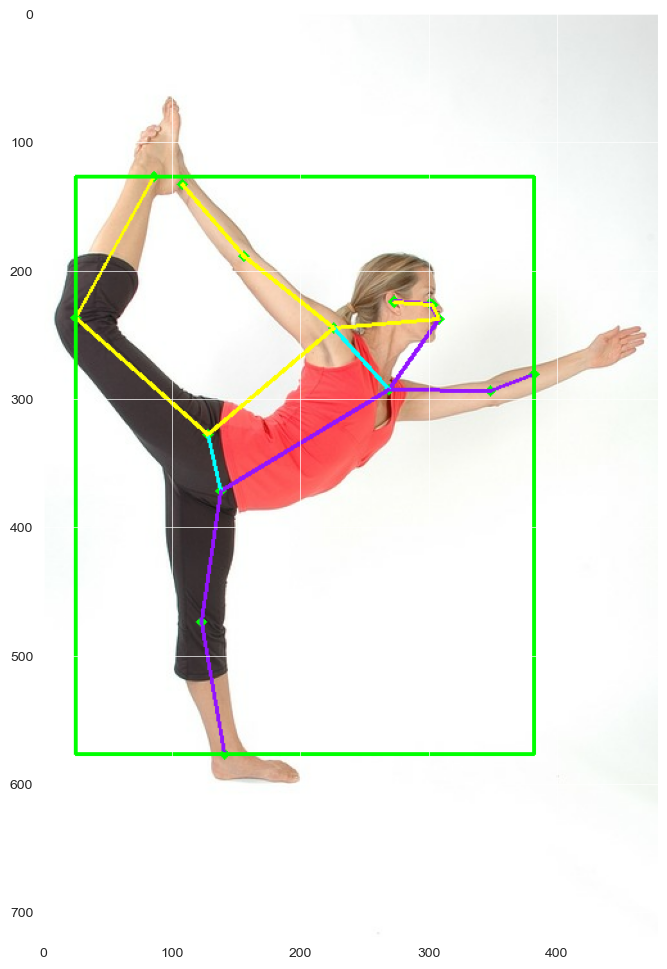

In [85]:

image = tf.io.read_file('temp_yoga.jpg')
image = tf.io.decode_jpeg(image)
person = detect(image)
_ = draw_prediction_on_image(image.numpy(), person, crop_region=None,
                             close_figure=False, keep_input_size=True)

In [86]:
import tqdm
# Training Set
images_in_train_folder = train_path
images_out_train_folder = train_path + 'poses_images_out_train'
csvs_out_train_path = 'train_data.csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_train_folder,
    images_out_folder=images_out_train_folder,
    csvs_out_path=csvs_out_train_path,
)

preprocessor.process(per_pose_class_limit=None)

# Test Set
images_in_test_folder = test_path
images_out_test_folder = test_path + 'poses_images_out_test'
csvs_out_test_path = 'test_data.csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_test_folder,
    images_out_folder=images_out_test_folder,
    csvs_out_path=csvs_out_test_path,
)

preprocessor.process(per_pose_class_limit=None)

Preprocessing downdog
100%|██████████| 223/223 [00:18<00:00, 11.79it/s]
Preprocessing goddess
100%|██████████| 180/180 [00:15<00:00, 11.38it/s]
Preprocessing plank
100%|██████████| 266/266 [00:20<00:00, 13.24it/s]
Preprocessing tree
100%|██████████| 160/160 [00:15<00:00, 10.44it/s]
Preprocessing warrior2
100%|██████████| 252/252 [00:21<00:00, 11.74it/s]
Preprocessing downdog


Skipped C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TRAIN/downdog\00000135.jpg. No pose was confidentally detected.
Skipped C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TRAIN/downdog\00000147.jpg. No pose was confidentally detected.
Skipped C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TRAIN/downdog\00000168.jpg. No pose was confidentally detected.
Skipped C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TRAIN/downdog\00000188.png. Image isn't in RGB format.
Skipped C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TRAIN/downdog\00000212.png. Image isn't in RGB format.
Skipped C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TRAIN/downdog\

100%|██████████| 97/97 [00:09<00:00, 10.23it/s]
Preprocessing goddess
100%|██████████| 80/80 [00:06<00:00, 12.01it/s]
Preprocessing plank
100%|██████████| 115/115 [00:14<00:00,  7.94it/s]
Preprocessing tree
100%|██████████| 69/69 [00:09<00:00,  7.29it/s]
Preprocessing warrior2
100%|██████████| 109/109 [00:11<00:00,  9.64it/s]

Skipped C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TEST/downdog\00000010.png. Image isn't in RGB format.
Skipped C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TEST/downdog\00000017.png. Image isn't in RGB format.
Skipped C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TEST/downdog\00000041.png. Image isn't in RGB format.
Skipped C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TEST/downdog\00000075.png. Image isn't in RGB format.
Skipped C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TEST/downdog\00000080.jpg. No pose was confidentally detected.
Skipped C:/Users/jaisw/OneDrive - University of Florida/Documents/pattern_recognition_class/final_project/DATASET/TEST/downdog\00000102.png. Image isn'

In [87]:
def load_pose_landmarks(csv_path):
    """Loads a CSV created by MoveNetPreprocessor.

    Returns:
      X: Detected landmark coordinates and scores of shape (N, 17 * 3)
      y: Ground truth labels of shape (N, label_count)
      classes: The list of all class names found in the dataset
      dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    classes = df_to_process.pop('class_name').unique()

    # Extract the labels
    y = df_to_process.pop('class_no')

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes, dataframe

# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)

# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

In [88]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""

    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.
    It is the maximum of two values:
      * Torso size multiplied by `torso_size_multiplier`
      * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                   BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                        BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                       BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                      [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                  name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size


def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
    scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP,
                                   BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center,
                                  [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

In [97]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)

adam_opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                             monitor='val_accuracy',
                                             verbose=1,
                                             save_best_only=True,
                                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=20)

# Start training
with tf.device('/device:gpu:0'):
    history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])



Epoch 1/200
52/52 [==============================] - 1s 9ms/step - loss: 1.4997 - accuracy: 0.4188 - val_loss: 1.3295 - val_accuracy: 0.6122

Epoch 00001: val_accuracy improved from -inf to 0.61224, saving model to weights.best.hdf5
Epoch 2/200
52/52 [==============================] - 0s 5ms/step - loss: 1.2018 - accuracy: 0.5656 - val_loss: 1.0149 - val_accuracy: 0.6667

Epoch 00002: val_accuracy improved from 0.61224 to 0.66667, saving model to weights.best.hdf5
Epoch 3/200
52/52 [==============================] - 0s 4ms/step - loss: 0.9925 - accuracy: 0.6089 - val_loss: 0.8545 - val_accuracy: 0.6463

Epoch 00003: val_accuracy did not improve from 0.66667
Epoch 4/200
52/52 [==============================] - 0s 4ms/step - loss: 0.9035 - accuracy: 0.6282 - val_loss: 0.7769 - val_accuracy: 0.6599

Epoch 00004: val_accuracy did not improve from 0.66667
Epoch 5/200
52/52 [==============================] - 0s 4ms/step - loss: 0.8763 - accuracy: 0.6258 - val_loss: 0.7422 - val_accuracy: 0.6

In [108]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 51)]         0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 17, 3)        0           input_5[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 17, 2)        0           reshape_1[0][0]                  
__________________________________________________________________________________________________
tf.compat.v1.gather_9 (TFOpLamb (None, 2)            0           tf.__operators__.getitem_1[0][0] 
____________________________________________________________________________________________

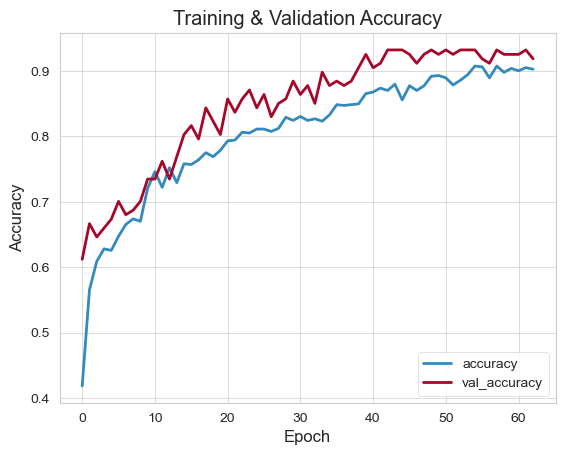

In [109]:
# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')
plt.show()


In [113]:
# confusion matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
# y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 88   0   1   0   0]
 [  0  64   1   0  12]
 [  0   0 107   0   0]
 [  0   0   0  65   0]
 [  0   2   0   0 102]]


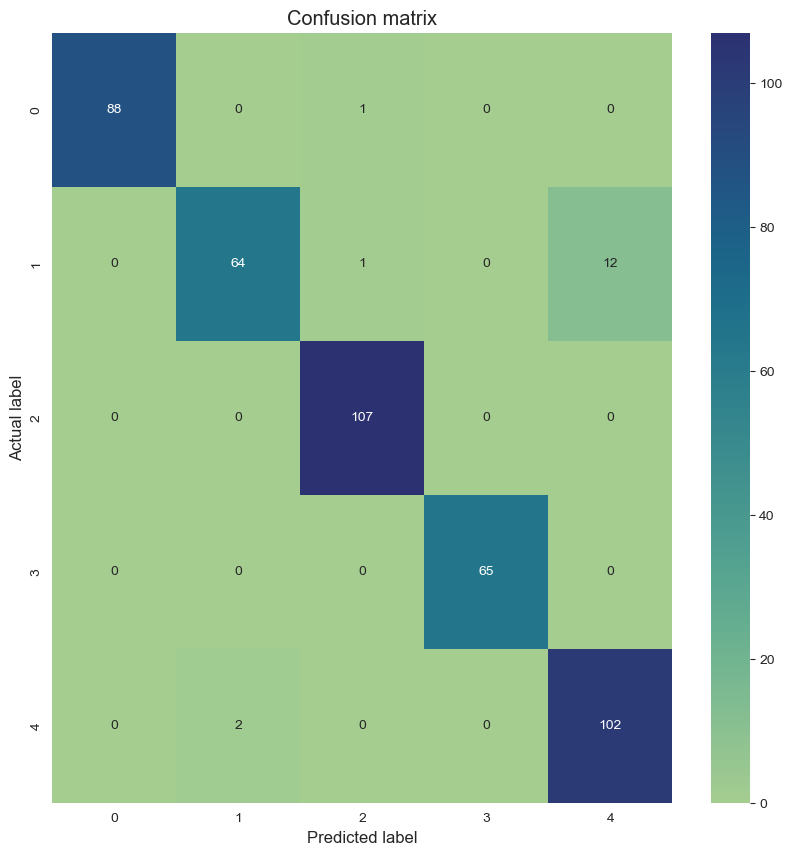

In [112]:
# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='crest')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [96]:
# Save the model
model.save('MoveNet_model.h5')
